In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pickle
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from direvo_functions import *
import selection_function_library as slct
import os
import tqdm

This is how to use the directed evolution code!

In [4]:
def directedEvolution(rng, 
                      selection_strategy, 
                      selection_params, 
                      empirical = False, 
                      N = None, 
                      K = None, 
                      landscape = None, 
                      popsize=100, 
                      mut_chance=0.01, 
                      num_steps=50, 
                      num_reps=10, 
                      define_i_pop=None, 
                      average=True):
    
    r1, r2 = jr.split(rng)
 
    # Get initial population.
    if define_i_pop == None:
        i_pop = np.array([jr.randint(r1, (N,), 0, 2)]*popsize)
    else:
        i_pop = define_i_pop
 
    # Function for evaluating fitness.
    if empirical:
        fitness_function = build_empirical_landscape_function(landscape)
        mutation_function = build_mutation_function(mut_chance, 20)
    else:
        fitness_function = build_NK_landscape_function(r2, N, K)
        mutation_function = build_mutation_function(mut_chance, 2)
 
    # Define selection function.
    selection_function = build_selection_function(
        selection_strategy, selection_params)
 
    # Bringing it all together.
    vmapped_run = jax.jit(jax.vmap(lambda r: run_directed_evolution(
        r, i_pop, selection_function, mutation_function, fitness_function=fitness_function, num_steps=num_steps)[1]))
    
    # The array of seeds we will take as input.
    rng_seeds = jr.split(rng, num_reps)
    results = vmapped_run(rng_seeds)
 
    return results

Next we define the parameters and run the code:

In [5]:
params = {'threshold': 0.95, 'base_chance' : 0.00}
rng = jr.PRNGKey(42)
run = directedEvolution(rng, 
                        N = 10, 
                        K=5, 
                        selection_strategy=slct.base_chance_threshold_select, 
                        selection_params = params, 
                        popsize=100, 
                        mut_chance=0.01, 
                        num_steps=100, 
                        num_reps=1, 
                        average=True)


2024-07-11 15:04:29.587177: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


And here we can plot the final result on this single run:

Text(0, 0.5, 'Fitness')

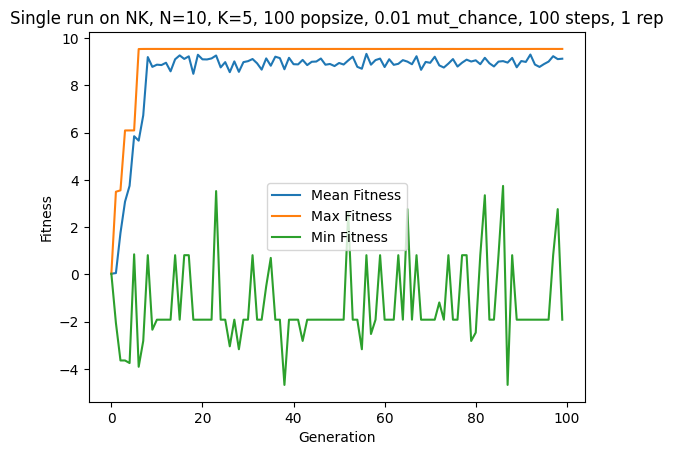

In [6]:
plt.plot(run["fitness"][0].mean(axis = 1), label = "Mean Fitness")
plt.plot(run["fitness"][0].max(axis = 1), label = "Max Fitness")
plt.plot(run["fitness"][0].min(axis = 1), label = "Min Fitness")
plt.legend()
plt.title(f"Single run on NK, N=10, K=5, 100 popsize, 0.01 mut_chance, 100 steps, 1 rep")
plt.xlabel("Generation")
plt.ylabel("Fitness")

And an example using GB1:

In [7]:
with open('landscape_arrays/GB1_landscape_array.pkl', 'rb') as f:
    GB1 = pickle.load(f)

rng = jr.PRNGKey(0)
i_pop_GB1 = jnp.array([[3,17,0,3]]*100)
GB1_run = directedEvolution(rng,
                            selection_strategy=slct.base_chance_threshold_select,
                            selection_params = {'threshold': 0.95, 'base_chance' : 0.0},
                            mut_chance=0.01,
                            num_steps=100,
                            num_reps=100,
                            define_i_pop=i_pop_GB1,
                            average=True,
                            empirical=True,
                            landscape=GB1)  

Text(0, 0.5, 'Fitness')

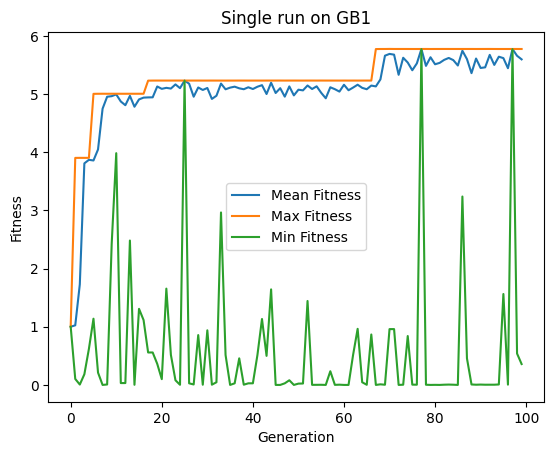

In [8]:
plt.plot(GB1_run["fitness"][0].mean(axis = 1), label = "Mean Fitness")
plt.plot(GB1_run["fitness"][0].max(axis = 1), label = "Max Fitness")
plt.plot(GB1_run["fitness"][0].min(axis = 1), label = "Min Fitness")
plt.legend()
plt.title("Single run on GB1")
plt.xlabel("Generation")
plt.ylabel("Fitness")

Example on TrpB:

In [10]:
with open('landscape_arrays/AAdict.pkl', 'rb') as f:
    AAdict = pickle.load(f)

In [13]:
AAdict['S']

18

In [22]:
with open('landscape_arrays/TrpB_landscape_array.pkl', 'rb') as f:
    TrpB = pickle.load(f)

TrpB = jnp.array(TrpB)

rng = jr.PRNGKey(1)
i_pop_TrpB = jnp.array([[3,8,3,18]]*100)
TrpB_run = directedEvolution(rng,
                            selection_strategy=slct.base_chance_threshold_select,
                            selection_params = {'threshold': 0.95, 'base_chance' : 0.0},
                            mut_chance=0.01,
                            num_steps=1000,
                            num_reps=100,
                            define_i_pop=i_pop_TrpB,
                            average=True,
                            empirical=True,
                            landscape=TrpB)  

Text(0, 0.5, 'Fitness')

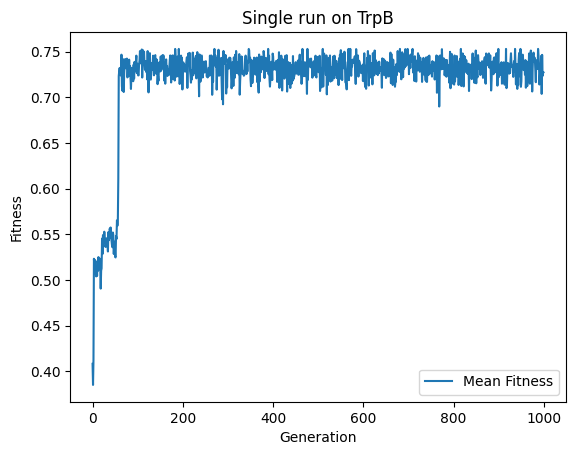

In [23]:
plt.plot(TrpB_run["fitness"][0].mean(axis = 1), label = "Mean Fitness")
plt.legend()
plt.title("Single run on TrpB")
plt.xlabel("Generation")
plt.ylabel("Fitness")